We train CIFAR10 using a DenseNet.
We use the provided keras version of the architecture: https://keras.io/api/applications/.

From [paperswithcode](https://paperswithcode.com/paper/densely-connected-convolutional-networks),
the should achieve ~96% natural accuracy.

### Load libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent

tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Load data

In [3]:
def plot_images(xs, flat=True, channels=1):
    for i, x in enumerate(xs):
        plt.subplot(1, len(xs), i + 1)
        plt.imshow(x)
        plt.axis("off")

x_train shape: (10000, 32, 32, 3)
10000 train samples
2000 test samples
[1 1 0 0 1 0 1 1 1 0]


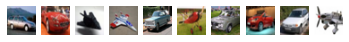

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Flatten labels
y_train = y_train.flatten()
y_test = y_test.flatten()

# Make binary classification
x_train = x_train[y_train < 2]
y_train = y_train[y_train < 2]
x_test = x_test[y_test < 2]
y_test = y_test[y_test < 2]

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

print(y_train[:10])
plot_images(x_train[:10])

### Build model and train

In [5]:
model = keras.applications.DenseNet121(
    weights=None,
    input_shape=x_train[0].shape,
    classes=2,
)
"""
keras.applications.MobileNetV2(
    input_shape=x_train[0].shape,
    weights=None,
    classes=2,
    classifier_activation=None,
) # Doesn't generalize at all...
"""

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer="adam",
    metrics=["accuracy"]
)

In [6]:
%%time
history = model.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=16,
    validation_data=(x_test, y_test),
    verbose=1,
);

Epoch 1/16
79/79 [==============================] - 37s 238ms/step - loss: 0.4804 - accuracy: 0.7982 - val_loss: 0.9182 - val_accuracy: 0.5000
Epoch 2/16
79/79 [==============================] - 5s 65ms/step - loss: 0.2316 - accuracy: 0.9054 - val_loss: 1.1300 - val_accuracy: 0.5000
Epoch 3/16
79/79 [==============================] - 5s 66ms/step - loss: 0.1578 - accuracy: 0.9334 - val_loss: 2.7946 - val_accuracy: 0.5000
Epoch 4/16
79/79 [==============================] - 5s 64ms/step - loss: 0.1168 - accuracy: 0.9555 - val_loss: 1.7229 - val_accuracy: 0.5135
Epoch 5/16
79/79 [==============================] - 5s 64ms/step - loss: 0.0960 - accuracy: 0.9632 - val_loss: 0.9703 - val_accuracy: 0.6695
Epoch 6/16
79/79 [==============================] - 5s 65ms/step - loss: 0.1029 - accuracy: 0.9619 - val_loss: 0.6424 - val_accuracy: 0.8040
Epoch 7/16
79/79 [==============================] - 5s 66ms/step - loss: 0.0620 - accuracy: 0.9778 - val_loss: 0.3615 - val_accuracy: 0.8880
Epoch 8/16


In [7]:
%%time
# model.save("models/cifar10-baseline/")
# model = keras.models.load_model("models/cifar10-baseline")

INFO:tensorflow:Assets written to: models/cifar10-baseline/assets
Wall time: 1min 6s


### Evaluate

In [9]:
art_model = TensorFlowV2Classifier(
    model=model,
    input_shape=x_test[0].shape,
    nb_classes=2,
    loss_object=keras.losses.SparseCategoricalCrossentropy(),
    clip_values=[x_test.min(), x_test.max()],
)
art_attack = ProjectedGradientDescent(
    art_model,
    norm=2,
    eps=2,
    eps_step=0.2,
    max_iter=20,
    batch_size=128,
)

x_train_adv = art_attack.generate(x_train[:2000], y=y_train[:2000])    
x_test_adv = art_attack.generate(x_test, y=y_test)

_, nat_train_acc = model.evaluate(x_train, y_train, verbose=0)
_, nat_test_acc = model.evaluate(x_test, y_test, verbose=0)
_, adv_train_acc = model.evaluate(x_train_adv, y_train[:2000], verbose=0)
_, adv_test_acc = model.evaluate(x_test_adv, y_test, verbose=0)

print("Nat train acc :", nat_train_acc)
print("Nat test  acc :", nat_test_acc)
print("Adv train acc :", adv_train_acc)
print("Adv test  acc :", adv_test_acc)

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train acc : 0.9585999846458435
Nat test  acc : 0.9265000224113464
Adv train acc : 0.07450000196695328
Adv test  acc : 0.07850000262260437


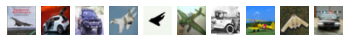

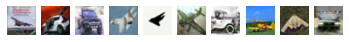

In [10]:
plot_images(x_test[:10])
plt.show()
plot_images(x_test_adv[:10])